In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from time import time

/home/uzumaki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class SinDataset:
    """Generates a random batch of sin in low
    and high range
    
    Parameters
    ----------
    low : lower bound
    high : high bound
    """
    def __init__(self, low, high):
        self.low = low
        self.high = high
        self.density = 0.1
     
    def next_batch(self, batch_size, steps, 
                   ret_ts=False):
        """Generates a random batch of sin
        
        Parameters
        ----------
        batch_size : the number of records to return
        
        steps : the number of entries in a single record
        """
        rand_start = np.random.rand(batch_size, 1)
        rand_start = rand_start * (self.high - self.low) + self.low
        X = rand_start + np.arange(0.0, steps + 1) * self.density
        y = np.sin(X).reshape(-1, steps + 1, 1)
        if ret_ts:
            return y[:, :-1], y[:, 1:], X
        else:
            return y[:, :-1], y[:, 1:]

In [4]:
sin_dataset = SinDataset(0, 10)
y0, y1, X = sin_dataset.next_batch(10, 8, True)

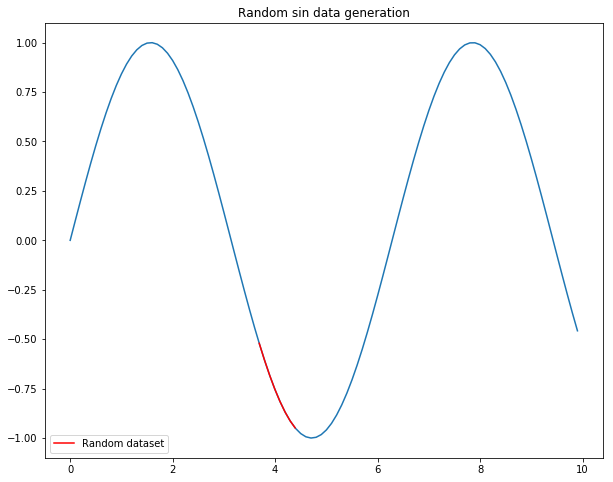

In [ ]:
X_plot = np.arange(0, 10, 0.1)
fig = plt.figure(figsize=(10, 8))
plt.title("Random sin data generation")
plt.plot(X_plot, np.sin(X_plot))
plt.plot(X[0][:-1], y0[0].ravel(), color="red", 
         label="Random dataset", markersize=10)
plt.legend()
plt.show()

In [ ]:
class RecurrentNeuralNetwork:
    def __init__(self):
        # reset graph to reinitialize nodes
        tf.reset_default_graph()
        
        self.n_input = 1
        self.n_hidden = 100
        self.n_output = 1
        self.n_iterations = 5001
        self.learning_rate = 0.0001
        self.batch_size = 1
        self.time_steps = 100
        self.MODEL_SAVE_PATH = "/content/rnn_model"
        self.X = tf.placeholder(tf.float32, shape=[None, self.time_steps,
                                                   self.n_input])
        self.y = tf.placeholder(tf.float32, shape=[None, self.time_steps,
                                                   self.n_output])
        
    def architecture(self):
        # Basic RNN Cell 
        cell = tf.contrib.rnn.BasicRNNCell(num_units=self.n_hidden,
                                           activation=tf.nn.relu)
        # Wrapper to get the required number of output neurons
        cell = tf.contrib.rnn.OutputProjectionWrapper(cell, 
                                                      output_size=self.n_output)
        # Perform Dynamic Unrolling of inputs
        y_pred, states = tf.nn.dynamic_rnn(cell, self.X, dtype=tf.float32)
        return y_pred, states
    
    def train(self):
        y_pred, states = self.architecture()
        # loss function
        loss = tf.losses.mean_squared_error(labels=self.y, predictions=y_pred)
        # setup optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        train = optimizer.minimize(loss)
        init = tf.global_variables_initializer()
        # create dataset
        sin_dataset = SinDataset(0, 10)
        # save model for later use
        saver = tf.train.Saver()
        with tf.Session() as sess:
            # initialize Variables
            sess.run(init)
            for i in range(self.n_iterations):
                start = time()
                X_batch, y_batch = sin_dataset.next_batch(self.batch_size,
                                                          self.time_steps)
                sess.run(train, feed_dict={self.X: X_batch, self.y: y_batch})
                mse = sess.run(loss, feed_dict={self.X: X_batch, 
                                                       self.y: y_batch})
                # debug info
                if i % 1000 == 0:
                    print("Iteration:{0}\tLoss: {1:.5f}\tTime: {2:.2f} sec/step"
                              .format(i, mse, (time() - start)))
            # save the model
            saver.save(sess, self.MODEL_SAVE_PATH)
            print("Saving model in: {}".format(self.MODEL_SAVE_PATH))
            # plotting test
            X_test, y_test, X_axes = sin_dataset.next_batch(self.batch_size,
                                                    self.time_steps, 
                                                    ret_ts=True)
            y_pred_test = sess.run(y_pred, feed_dict={self.X: X_test})
            fig = plt.figure(figsize=(10, 8))
            plt.title("RNN prediction")
            plt.scatter(X_axes[:, 1:], np.sin(X_axes[:, 1:]), label="Actual",
                        s=135, alpha=0.5, edgecolors="b")
            plt.scatter(X_axes[:, 1:], y_pred_test, label="Predicted", 
                        edgecolors="b", color="red")
            plt.legend()

Iteration:0	Loss: 0.47199	Time: 0.09 sec/step
Iteration:1000	Loss: 0.00179	Time: 0.02 sec/step
Iteration:2000	Loss: 0.00139	Time: 0.02 sec/step
Iteration:3000	Loss: 0.00045	Time: 0.02 sec/step
Iteration:4000	Loss: 0.00008	Time: 0.02 sec/step
Iteration:5000	Loss: 0.00013	Time: 0.02 sec/step
Saving model in: /content/rnn_model


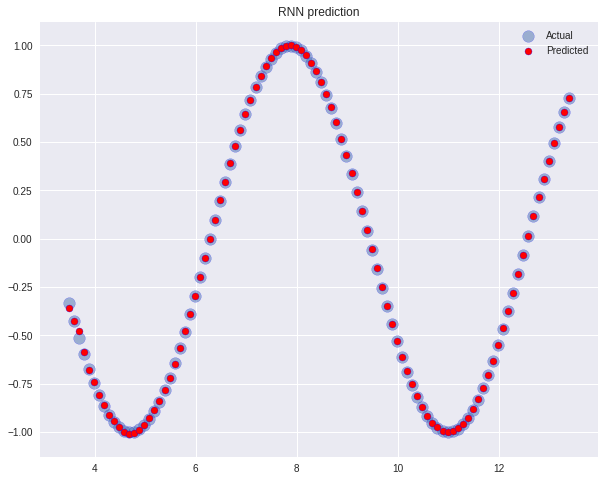

In [55]:
rnn = RecurrentNeuralNetwork().train()